# Bibliotheken importeren

In [30]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import math

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
from sklearn.cluster import KMeans
"""
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
"""

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn import tree\nfrom sklearn import metrics\nfrom sklearn.utils.multiclass import unique_labels\nfrom sklearn.metrics import classification_report\n'

# Data inlezen en kolommen selecteren

In [8]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!
def ssms_to_sqlite():
    DB = {'servername': r'LAPTOP-NBUM6TMN',
        'database': 'johari'}

    ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                        ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
    ssms_cursor = ssms_conn.cursor()

    # Data inlezen van de benodigde tabellen
    returned_item = pd.read_sql("SELECT * FROM rSALES_STAFF", ssms_conn)
    order_details = pd.read_sql("SELECT * FROM SALES_BRANCH", ssms_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    returned_item.to_sql('SALES_STAFF', con=sqlite_conn, if_exists='replace', index=False)
    order_details.to_sql('SALES_BRANCH', con=sqlite_conn, if_exists='replace', index=False)

def data_to_sqlite():
    # Data inlezen van de benodigde tabellen
    go_sales_conn = sqlite3.connect('../data/go_sales.sqlite')
    sales_branch = pd.read_sql("SELECT * FROM sales_branch", go_sales_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    sales_branch.to_sql('SALES_BRANCH', con=sqlite_conn, if_exists='replace', index=False)

# ssms_to_sqlite()
# data_to_sqlite()

In [13]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
sales_branch = pd.read_sql("SELECT * FROM SALES_BRANCH", sqlite_conn)

df = sales_branch.loc[:, ['SALES_BRANCH_CODE', 'COUNTRY_CODE']]
df.head()

,SALES_BRANCH_CODE,COUNTRY_CODE
0,13,2
1,14,2
2,15,10
3,17,4
4,18,4


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [50]:
"""
dummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding
dummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen
dummies_dataframe.head()
"""

"\ndummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding\ndummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen\ndummies_dataframe.head()\n"

In [51]:
"""
df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen
df = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen
df.head()
"""

"\ndf = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen\ndf = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen\ndf = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen\ndf.head()\n"

# Clusteringmodel bouwen met 2 dimensies

In [24]:
df_2d = df.loc[:, ['SALES_BRANCH_CODE', 'COUNTRY_CODE']]

df_2d['SALES_BRANCH_CODE'] = df_2d['SALES_BRANCH_CODE'].astype(float)
df_2d['COUNTRY_CODE'] = df_2d['COUNTRY_CODE'].astype(float)

df_2d.head()

,SALES_BRANCH_CODE,COUNTRY_CODE
0,13.0,2.0
1,14.0,2.0
2,15.0,10.0
3,17.0,4.0
4,18.0,4.0


In [25]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1])

In [26]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,31.800000,13.800000
1,10.666667,4.666667
2,20.000000,3.000000


In [28]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,SALES_BRANCH_CODE,COUNTRY_CODE
0,31.800000,13.800000
1,10.666667,4.666667
2,20.000000,3.000000


In [31]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		13.0 - 31.8 = -18.8
		2.0 - 13.8 = -11.8
	Totale euclidische som: 492.68000000000006
	Euclidische afstand: 22.19639610387236
------------------------------------------------
	Centrumindex 1:
		13.0 - 10.666666666666668 = 2.333333333333332
		2.0 - 4.666666666666667 = -2.666666666666667
	Totale euclidische som: 12.555555555555552
	Euclidische afstand: 3.543381937578216
------------------------------------------------
	Centrumindex 2:
		13.0 - 20.0 = -7.0
		2.0 - 3.0 = -1.0
	Totale euclidische som: 50.0
	Euclidische afstand: 7.0710678118654755
------------------------------------------------
{0: 22.19639610387236, 1: 3.543381937578216, 2: 7.0710678118654755}
1
Afstand van bronindex 1 tot...
	Centrumindex 0:
		14.0 - 31.8 = -17.8
		2.0 - 13.8 = -11.8
	Totale euclidische som: 456.08000000000004
	Euclidische afstand: 21.35602959353634
------------------------------------------------
	Centrumindex 1:
		14.0 - 10.666666666666668 = 3.33333333333

,SALES_BRANCH_CODE,COUNTRY_CODE,Centrum
0,13.0,2.0,1.0
1,14.0,2.0,1.0
2,15.0,10.0,1.0
3,17.0,4.0,2.0
4,18.0,4.0,2.0
5,19.0,3.0,2.0
6,20.0,3.0,2.0
7,21.0,3.0,2.0
8,22.0,3.0,2.0
9,23.0,1.0,2.0


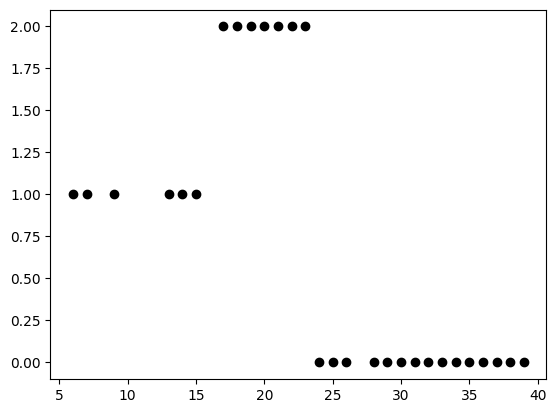

In [33]:
plt.scatter(df_2d['SALES_BRANCH_CODE'], df_2d['Centrum'], color = 'k')
plt.show()

In [34]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,15
1,6
2,7
